# 1. Environment Setup

In [1]:
import gurobipy as gp
from gurobipy import GRB
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Data Acquisition

### 2.1 Variables Definition

In [2]:
alloy = ['all_1','all_2','all_3','all_4','all_5']
supplier = ['sup_1','sup_2','sup_3','sup_4','sup_5']
product = ['prod_1','prod_2','prod_3']
month = ['Int', 'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
I = len(alloy)
J = len(supplier)
Z = len(product)
M = len(month)
q = 0.05
mu = 1

In [3]:
x_name = []
for i in alloy:
    for j in supplier:
        for m in month:
            #value = 'units of '+i+' sourced from '+j+' in '+m
            value = 'order '+i+' | '+j+' | '+m
            x_name.append(value)
            
s_name = []
for m in month:
    for z in product:
        #value = 'units of '+z+' delayed by one month on '+m
        value = 'delay '+z+' | '+m
        s_name.append(value)
        
D_name = []
for m in month:
    for z in product:
        #value = 'units of '+z+' delivered to satisfy demand in '+m
        value = 'deliver '+z+' | '+m
        D_name.append(value)

lambda_1_name = []
for i in alloy:
    for j in supplier:
        for m in month:
            #value = 'if contract upper range exceeded for '+i+' from '+j+' on month '+m
            value = 'exceed '+i+' | '+j+' | '+m
            lambda_1_name.append(value)

lambda_2_name = []
for i in alloy:
    for j in supplier:
        for m in month:
            #value = 'if contract lower range exceeded for '+i+' from '+j+' on month '+m
            value = 'surrender '+i+' | '+j+' | '+m
            lambda_2_name.append(value)

### 2.2 Data Filepath

In [4]:
file_loc = 'Data Templates_v5.xlsx'

### 2.3 Contract Upper Threshold

In [5]:
contract_upper_threshold = pd.read_excel(file_loc,sheet_name='Contract Upper Threshold',header=2, na_values=['NA'], usecols="B:F")
contract_upper_threshold.index=alloy

In [6]:
h = contract_upper_threshold
contract_upper_threshold

,Supp A,Supp B,Supp C,Supp D,Supp E
all_1,1500,1000,1500,1000,1200
all_2,10000,2500,7500,7500,5000
all_3,10000,3000,6000,4500,1800
all_4,450,250,450,300,100
all_5,500,250,450,300,200


### 2.4 Contract Lower Threshold

In [7]:
contract_lower_threshold = pd.read_excel(file_loc,sheet_name='Contract Lower Threshold',header=2, na_values=['NA'], usecols="B:F")
contract_lower_threshold.index=alloy

In [8]:
l = contract_lower_threshold
contract_lower_threshold

,Supp A,Supp B,Supp C,Supp D,Supp E
all_1,300,400,450,550,400
all_2,5000,800,1800,1000,420
all_3,1500,1200,2500,2000,800
all_4,42,100,85,100,75
all_5,84,100,100,120,50


### 2.5 Contract Penalties

In [9]:
contract_penalties = pd.read_excel(file_loc,sheet_name='Contract Penalties',header=2, na_values=['NA'], usecols="B:F")
contract_penalties.index=['Penalty Fee %']

In [10]:
p = contract_penalties
contract_penalties

,Supp A,Supp B,Supp C,Supp D,Supp E
Penalty Fee %,0.8,0.6,0.75,0.7,0.5


### 2.6 Annual Contract Limit

In [11]:
annual_contracted_limit= pd.read_excel(file_loc,sheet_name='Annual Contracted Limit',header=2, na_values=['NA'], usecols="B:F")
annual_contracted_limit = annual_contracted_limit.iloc[:5,:]
annual_contracted_limit.index=alloy

In [12]:
k = annual_contracted_limit
annual_contracted_limit

,Supp A,Supp B,Supp C,Supp D,Supp E
all_1,9616.2,6956.5,7871.0,7867.8,11807.5
all_2,67200.0,33600.0,22400.0,44800.0,56000.0
all_3,17600.0,44000.0,35200.0,35200.0,44000.0
all_4,1560.0,1872.0,1768.0,3120.0,2080.0
all_5,1356.0,3616.0,2938.0,1130.0,2260.0


### 2.7 Unit Cost

In [13]:
unit_cost = pd.read_excel(file_loc,sheet_name='Unit Cost',header=2, na_values=['NA'], usecols="B:F")
unit_cost = unit_cost.iloc[:5,:]
unit_cost.index=alloy

In [14]:
c = unit_cost
unit_cost

,Supp A,Supp B,Supp C,Supp D,Supp E
all_1,275.000000,274.166667,274.583333,274.416667,273.750000
all_2,11.250000,10.666667,11.083333,10.833333,10.416667
all_3,2.333333,1.833333,2.166667,2.000000,1.666667
all_4,858.333333,855.000000,857.083333,855.833333,853.333333
all_5,210.833333,204.166667,208.333333,205.833333,202.500000


### 2.8 Product Revenue

In [15]:
prod_rev = pd.read_excel(file_loc,sheet_name='Prod Rev',header=2, na_values=['NA'], usecols="B:F")
prod_rev.index=['Revenue ($)']

D:\anaconda\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


In [16]:
r = prod_rev
prod_rev

,Prod 1,Prod 2,Prod 3
Revenue ($),20000,22000,25000


### 2.9 Product Recipe

In [17]:
prod_recipe= pd.read_excel(file_loc,sheet_name='Prod Recipe',header=2, na_values=['NA'], usecols="B:D")
prod_recipe = prod_recipe.iloc[:5,:]
prod_recipe.index=alloy

In [18]:
u = prod_recipe
prod_recipe

,Prod 1,Prod 2,Prod 3
all_1,26.226,49.670455,0.000000
all_2,112.000,152.727273,81.454545
all_3,88.000,40.000000,256.000000
all_4,4.160,11.818182,7.563636
all_5,0.000,15.409091,12.327273


### 2.10 Seasonal Demand

In [19]:
seasonal_demand= pd.read_excel(file_loc,sheet_name='Seasonal Demand',header=2, na_values=['NA'], usecols="B:D")
seasonal_demand.index=month

In [20]:
d = seasonal_demand
seasonal_demand

,Prod 1,Prod 2,Prod 3
Int,0.0,0.0,0.0
Jan,82.5,27.5,35.2
Feb,66.0,24.2,30.8
Mar,44.0,22.0,26.4
Apr,44.0,19.8,24.2
May,39.6,16.5,22.0
Jun,35.2,13.2,16.5
Jul,33.0,11.0,13.2
Aug,35.2,11.0,16.5
Sep,38.5,15.4,16.5


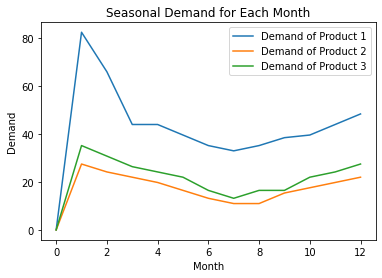

In [21]:
# plot lines

plt.plot(list(range(13)), d['Prod 1'], label = "Demand of Product 1")
plt.plot(list(range(13)), d['Prod 2'], label = "Demand of Product 2")
plt.plot(list(range(13)), d['Prod 3'], label = "Demand of Product 3")
plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Seasonal Demand for Each Month')
plt.legend()
plt.show()

# 3. Gurobi

In [22]:
model = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-25


### 3.1 Decision variables:

$ x_{i,j,m} $ how much of alloy type $ i $ to source from supplier $ j $ in month $ m $

$ s_{m, z} $ how many units of product type $ z $ will be delayed by one month on month $ m $

$ D_{m, z} $ how many units of product type $ z $ were delivered to satisfy demand on month $ m $

$ \lambda^1_{i, j, m} $ a variable indicating how much the order exceeded the upper contract threshold for alloy $i$ from supplier $j$ on month $m$

$ \lambda^2_{i, j, m} $ a variable indicating how much the order fell short of the lower contract threshold for alloy $i$ from supplier $j$ on month $m$

In [23]:
x = model.addVars(I, J, M, vtype=GRB.CONTINUOUS, lb=0, name=x_name)
s = model.addVars(M,Z, vtype=GRB.CONTINUOUS, lb=0, name=s_name)
D = model.addVars(M,Z, vtype=GRB.CONTINUOUS, lb=0, name=D_name)
lambda1 = model.addVars(I, J, M, vtype=GRB.CONTINUOUS, lb=0, name=lambda_1_name)
lambda2 = model.addVars(I, J, M, vtype=GRB.CONTINUOUS, lb=0, name=lambda_2_name)
total_cost = model.addVar(1,vtype=GRB.CONTINUOUS, name='Total Cost')

### 3.2 Objective function

Maximize 

$$
\sum \limits _{m=1} ^{12}\sum \limits _{z=1} ^{3} D_{m, z} r_{z} - \sum \limits _{m=1} ^{12}\sum \limits _{z=1} ^{3} s_{m, z} r_{z}q - \sum \limits _{i=1} ^{5}\sum \limits _{j=1} ^{5}\sum \limits _{m=1} ^{12} c_{i,j}x_{i,j,m} - \sum \limits _{i=1} ^{5}\sum \limits _{j=1} ^{5}\sum \limits _{m=1} ^{12} \lambda^{1}_{i,j,m}p_{j}c_{i,j} - \sum \limits _{i=1} ^{5}\sum \limits _{j=1} ^{5}\sum \limits _{m=1} ^{12} \lambda^{2}_{i,j,m}p_{j}c_{i,j} $$

In [24]:
revenue = sum(D[m,z]*r.iloc[0,z] for m in range(1, M) for z in range(Z))
delay = sum(s[m,z]*r.iloc[0,z]*q for m in range(1, M) for z in range(Z))
cost = sum(c.iloc[i,j]*x[i,j,m] for i in range(I) for j in range(J) for m in range(1, M))
high = sum(lambda1[i,j,m]*p.iloc[0,j]*c.iloc[i, j] for i in range(I) for j in range(J) for m in range(1, M))
low = sum(lambda2[i,j,m]*p.iloc[0,j]*c.iloc[i, j] for i in range(I) for j in range(J) for m in range(1, M))

In [25]:
model.setObjective(revenue-delay-cost-high-low,GRB.MAXIMIZE)

### 3.3 Constraints:

**Capacity**

$ \sum \limits _{m=1} ^{12} x_{i,j,m} \le k_{i,j} $ $ \forall i = 1,...,5$ and $j = 1,...5 $

In [26]:
for i in range(I):
    for j in range(J):
        model.addConstr(sum(x[i,j,m] for m in range(1, M))<=k.iloc[i,j], name = "capacity_"+str(i)+str(j))

**Month 0 Constraints**
    
$ x_{i,j,m=0} = s_{m=0,z} = D_{m=0} = \lambda^1_{i, j, m=0} = \lambda^2_{i, j, m=0} = 0$ $\forall i = 1, ..., 5$, $j = 1, ..., 5 $, and $ z = 1, .., 3$

In [27]:
model.addConstrs(x[i,j,0]==0 for i in range(I) for j in range(J))
model.addConstrs(lambda1[i,j,0]==0 for i in range(I) for j in range(J))
model.addConstrs(lambda2[i,j,0]==0 for i in range(I) for j in range(J))
model.addConstrs(s[0,z]==0 for z in range(Z))
model.addConstrs(D[0,z]==0 for z in range(Z))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>}

**Enough Alloys are Sourced to Meet Delivery Requirements (no inventory passed on to next month)**
    
$\sum \limits _{j=1} ^{5} x_{i,j,m} = \sum \limits _{z=1} ^{3} D_{m,z} u_{i,z}  $ $ \forall m = 1,...,12 $ and $i = 1, ..., 5 $

In [28]:
for m in range(1, M):
    for i in range(I):
        model.addConstr(sum(x[i,j,m] for j in range(J))==sum(D[m,z]*u.iloc[i,z]/12 for z in range(Z)), name = "need_"+str(m)+str(i)) 

**Maximum Delay Capacity**

$s_{m, z} \le \mu (d_{m, z}+s_{m-1, z}) $ $ \forall m = 1,...,12 $ and $ z = 1,...,3 $

In [29]:
for m in range(1, M):
    for z in range(Z):
        model.addConstr(s[m,z]<=mu*(d.iloc[m,z]+s[m-1,z]), name = "maxDelay_"+str(m)+str(z))

**Demand Delivered per Month**

$D_{m, z} = s_{m-1, z} + d_{m, z} - s_{m, z} $ $ \forall m = 1, ..., 12$ and $ z = 1, ..., 3 $

In [30]:
model.addConstrs(s[0,z]==0 for z in range(Z))

for m in range(1,M):
    for z in range(Z):
        model.addConstr(D[m,z] == s[m-1,z] + d.iloc[m,z] - s[m,z], name = "delivery_"+str(m)+str(z))

**Meet All Demand Predicted Within the Year**

$\sum \limits _{m=1}^{12} D_{m,z} = \sum \limits _{m=1}^{12} d_{m, z} $

In [31]:
for z in range(Z):
    model.addConstr(sum(D[m,z] for m in range(1, M)) == sum(d.iloc[m,z] for m in range(1, M)), name = "allDemand_"+str(z))

**Upper limit penalty**

$  x_{i,j,m} - h_{i,j} \le \lambda^1_{i, j, m} $ $\forall i = 1,...,5 $,  $ j = 1,...,5 $, and $ m = 1,...,12 $

In [32]:
for i in range(I):
    for j in range(J):
        for m in range(M):
            model.addConstr(x[i,j,m]-h.iloc[i,j] <= lambda1[i,j,m],name = "upper_"+str(i)+str(j)+str(m))

**Lower limit penalty**

$ l_{i,j} - x_{i,j,m} \lambda^2_{i, j, m}  \forall i = 1,...,5 $, $ j = 1,...,5 $, and $ m = 1,...,12 $

In [33]:
for i in range(I):
    for j in range(J):
        for m in range(1, M):
            model.addConstr(l.iloc[i,j]-x[i,j,m] <= lambda2[i,j,m],name = "lower_"+str(i)+str(j)+str(m))

**Non-negativity constraints**

$ x_{i,j,m} \ge 0$ $ \forall i = 1,...,5 $, $ j = 1,...,5 $, and $ m = 1,...,12 $

$ s_{m, z} \ge 0$ $\forall m = 1,...,12 $ and $ z = 1,...,3 $

$ D_{m, z} \ge 0$ $\forall m = 1,...,12 $ and $ z = 1,...,3 $

$ \lambda^1_{i, j, m} \ge 0$  $\forall i = 1,...,5$, $ j=1, ..., 5$, and $ m = 1,...,12 $

$ \lambda^2_{i, j, m} \ge 0$  $\forall i = 1,...,5$, $ j=1, ..., 5$, and $ m = 1,...,12 $

In [34]:
# these constraints are already applied while setting up decision variables

**Calculating total cost**

In [35]:
model.addConstr(total_cost==delay+cost+high+low)

<gurobi.Constr *Awaiting Model Update*>

# 4. Result

In [36]:
model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 870 rows, 1054 columns and 3243 nonzeros
Model fingerprint: 0x8a030cdd
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [8e-01, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 7e+04]
Presolve removed 115 rows and 85 columns
Presolve time: 0.01s
Presolved: 755 rows, 969 columns, 3093 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5842139e+08   2.029113e+05   0.000000e+00      0s
     392    1.3294273e+07   0.000000e+00   0.000000e+00      0s

Solved in 392 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.329427329e+07


In [37]:
if model.status == GRB.OPTIMAL:
    model.printAttr('X')


    Variable            X 
-------------------------
order all_1 | sup_1 | Jan      294.132 
order all_1 | sup_1 | Feb      244.412 
order all_1 | sup_1 | Mar      187.224 
order all_1 | sup_1 | Apr      178.118 
order all_1 | sup_1 | May      154.843 
order all_1 | sup_1 | Jun      131.567 
order all_1 | sup_1 | Jul      117.653 
order all_1 | sup_1 | Aug      122.461 
order all_1 | sup_1 | Sep      147.885 
order all_1 | sup_1 | Oct      159.396 
order all_1 | sup_1 | Nov      178.118 
order all_1 | sup_1 | Dec      196.841 
order all_2 | sup_1 | Jan      1358.93 
order all_2 | sup_1 | Feb      1133.07 
order all_2 | sup_1 | Mar      869.867 
order all_2 | sup_1 | Apr      826.933 
order all_2 | sup_1 | May      728.933 
order all_2 | sup_1 | Jun      608.533 
order all_2 | sup_1 | Jul        537.6 
order all_2 | sup_1 | Aug      580.533 
order all_2 | sup_1 | Sep      667.333 
order all_2 | sup_1 | Oct      742.933 
order all_2 | sup_1 | Nov      826.933 
order all_2 | sup_1 | Dec 

surrender all_2 | sup_3 | Dec         1800 
surrender all_2 | sup_4 | Jan         1000 
surrender all_2 | sup_4 | Feb         1000 
surrender all_2 | sup_4 | Mar         1000 
surrender all_2 | sup_4 | Apr         1000 
surrender all_2 | sup_4 | May         1000 
surrender all_2 | sup_4 | Jun         1000 
surrender all_2 | sup_4 | Jul         1000 
surrender all_2 | sup_4 | Aug         1000 
surrender all_2 | sup_4 | Sep         1000 
surrender all_2 | sup_4 | Oct         1000 
surrender all_2 | sup_4 | Nov         1000 
surrender all_2 | sup_4 | Dec         1000 
surrender all_2 | sup_5 | Jan          420 
surrender all_2 | sup_5 | Feb          420 
surrender all_2 | sup_5 | Mar          420 
surrender all_2 | sup_5 | Apr          420 
surrender all_2 | sup_5 | May          420 
surrender all_2 | sup_5 | Jun          420 
surrender all_2 | sup_5 | Jul          420 
surrender all_2 | sup_5 | Aug          420 
surrender all_2 | sup_5 | Sep          420 
surrender all_2 | sup_5 | Oct   

surrender all_5 | sup_5 | Mar           50 
surrender all_5 | sup_5 | Apr           50 
surrender all_5 | sup_5 | May           50 
surrender all_5 | sup_5 | Jun           50 
surrender all_5 | sup_5 | Jul           50 
surrender all_5 | sup_5 | Aug           50 
surrender all_5 | sup_5 | Sep           50 
surrender all_5 | sup_5 | Oct           50 
surrender all_5 | sup_5 | Nov           50 
surrender all_5 | sup_5 | Dec           50 
  Total Cost  9.42073e+06 


In [38]:
def sen_report(model):
    print('Sensitivity Analysis (SA)\n ObjVal =', model.ObjVal)
    model.printAttr(['X', 'Obj', 'SAObjLow', 'SAObjUp'])
    model.printAttr(['X', 'RC', 'LB', 'SALBLow', 'SALBUp', 'UB', 'SAUBLow', 'SAUBUp'])
    model.printAttr(['Sense', 'Slack', 'Pi', 'RHS', 'SARHSLow', 'SARHSUp']) # Pi = shadow price
    # NOTE: printAttr prints only rows with at least one NON-ZERO value, e.g. model.printAttr('X') prints only non-zero variable values

In [39]:
sen_report(model)

Sensitivity Analysis (SA)
 ObjVal = 13294273.289027752

    Variable            X          Obj     SAObjLow      SAObjUp 
----------------------------------------------------------------
order all_1 | sup_1 | Int            0            0         -inf           -0 
order all_1 | sup_1 | Jan      294.132         -275     -288.646     -268.242 
order all_1 | sup_1 | Feb      244.412         -275     -288.646     -9.24846 
order all_1 | sup_1 | Mar      187.224         -275     -288.646     -9.24846 
order all_1 | sup_1 | Apr      178.118         -275     -288.646     -9.24846 
order all_1 | sup_1 | May      154.843         -275     -288.646     -9.24846 
order all_1 | sup_1 | Jun      131.567         -275     -281.758     -19.3853 
order all_1 | sup_1 | Jul      117.653         -275     -288.646     -9.24846 
order all_1 | sup_1 | Aug      122.461         -275     -288.646     -9.24846 
order all_1 | sup_1 | Sep      147.885         -275     -288.646     -9.24846 
order all_1 | sup_1 | O

order all_2 | sup_3 | Nov            0     -11.0833         -inf     -10.5625 
order all_2 | sup_3 | Dec            0     -11.0833         -inf     -10.5625 
order all_2 | sup_4 | Int            0            0         -inf           -0 
order all_2 | sup_4 | Jan            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Feb            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Mar            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Apr            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | May            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Jun            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Jul            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Aug            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Sep            0     -10.8333         -inf     -9.83333 
order all_2 | sup_4 | Oct            0     -10.8333 

order all_4 | sup_1 | Nov           42     -858.333     -900.938     -214.271 
order all_4 | sup_1 | Dec           42     -858.333     -900.938     -214.271 
order all_4 | sup_2 | Int            0            0         -inf           -0 
order all_4 | sup_2 | Jan            0         -855         -inf     -727.271 
order all_4 | sup_2 | Feb            0         -855         -inf     -727.271 
order all_4 | sup_2 | Mar            0         -855         -inf     -727.271 
order all_4 | sup_2 | Apr            0         -855         -inf     -727.271 
order all_4 | sup_2 | May            0         -855         -inf     -727.271 
order all_4 | sup_2 | Jun            0         -855         -inf     -684.667 
order all_4 | sup_2 | Jul            0         -855         -inf     -684.667 
order all_4 | sup_2 | Aug            0         -855         -inf     -684.667 
order all_4 | sup_2 | Sep            0         -855         -inf     -684.667 
order all_4 | sup_2 | Oct            0         -855 

order all_5 | sup_4 | Nov            0     -205.833         -inf      -186.25 
order all_5 | sup_4 | Dec            0     -205.833         -inf      -186.25 
order all_5 | sup_5 | Int            0            0         -inf           -0 
order all_5 | sup_5 | Jan            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Feb            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Mar            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Apr            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | May            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Jun            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Jul            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Aug            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Sep            0       -202.5         -inf     -143.417 
order all_5 | sup_5 | Oct            0       -202.5 

exceed all_1 | sup_2 | Apr            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | May            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Jun            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Jul            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Aug            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Sep            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Oct            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Nov            0       -164.5         -inf           -0 
exceed all_1 | sup_2 | Dec            0       -164.5         -inf           -0 
exceed all_1 | sup_3 | Int            0            0         -inf           -0 
exceed all_1 | sup_3 | Jan            0     -205.938         -inf           -0 
exceed all_1 | sup_3 | Feb            0     -205.938         -inf           -0 
exceed all_1 | sup_3 | Mar            0 

exceed all_2 | sup_5 | Mar            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Apr            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | May            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Jun            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Jul            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Aug            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Sep            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Oct            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Nov            0     -5.20833         -inf           -0 
exceed all_2 | sup_5 | Dec            0     -5.20833         -inf           -0 
exceed all_3 | sup_1 | Int            0            0         -inf           -0 
exceed all_3 | sup_1 | Jan            0     -1.86667         -inf           -0 
exceed all_3 | sup_1 | Feb            0 

exceed all_4 | sup_3 | Feb            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Mar            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Apr            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | May            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Jun            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Jul            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Aug            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Sep            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Oct            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Nov            0     -642.812         -inf           -0 
exceed all_4 | sup_3 | Dec            0     -642.812         -inf           -0 
exceed all_4 | sup_4 | Int            0            0         -inf           -0 
exceed all_4 | sup_4 | Jan            0 

surrender all_1 | sup_1 | Jan      5.86813         -220     -226.758     -206.354 
surrender all_1 | sup_1 | Feb      55.5883         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Mar      112.776         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Apr      121.882         -220     -485.752     -206.354 
surrender all_1 | sup_1 | May      145.157         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Jun      168.433         -220     -475.615     -213.242 
surrender all_1 | sup_1 | Jul      182.347         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Aug      177.539         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Sep      152.115         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Oct      140.604         -220     -495.888     -206.354 
surrender all_1 | sup_1 | Nov      121.882         -220     -485.752     -206.354 
surrender all_1 | sup_1 | Dec      103.159         -220     -485.752     -206.354 
surr

surrender all_2 | sup_3 | Sep         1800      -8.3125     -8.83333           -0 
surrender all_2 | sup_3 | Oct         1800      -8.3125     -8.83333           -0 
surrender all_2 | sup_3 | Nov         1800      -8.3125     -8.83333           -0 
surrender all_2 | sup_3 | Dec         1800      -8.3125     -8.83333           -0 
surrender all_2 | sup_4 | Int            0            0         -inf          inf 
surrender all_2 | sup_4 | Jan         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | Feb         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | Mar         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | Apr         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | May         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | Jun         1000     -7.58333     -8.58333           -0 
surrender all_2 | sup_4 | Jul         1000     -7.58333     -8.58333           -0 
surr

surrender all_4 | sup_1 | Apr            0     -686.667         -inf     -644.062 
surrender all_4 | sup_1 | May            0     -686.667         -inf     -644.062 
surrender all_4 | sup_1 | Jun      6.39733     -686.667     -1760.99     -644.063 
surrender all_4 | sup_1 | Jul      11.4067     -686.667     -1803.59     -644.062 
surrender all_4 | sup_1 | Aug        8.564     -686.667     -1803.59     -644.062 
surrender all_4 | sup_1 | Sep      3.08667     -686.667     -1803.59     -644.062 
surrender all_4 | sup_1 | Oct            0     -686.667         -inf     -644.062 
surrender all_4 | sup_1 | Nov            0     -686.667         -inf     -644.062 
surrender all_4 | sup_1 | Dec            0     -686.667         -inf     -644.062 
surrender all_4 | sup_2 | Int            0            0         -inf          inf 
surrender all_4 | sup_2 | Jan          100         -513     -640.729           -0 
surrender all_4 | sup_2 | Feb          100         -513     -640.729           -0 
surr

surrender all_5 | sup_3 | Dec          100      -156.25     -166.167           -0 
surrender all_5 | sup_4 | Int            0            0         -inf          inf 
surrender all_5 | sup_4 | Jan          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Feb          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Mar          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Apr          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | May          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Jun          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Jul          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Aug          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Sep          120     -144.083     -163.667           -0 
surrender all_5 | sup_4 | Oct          120     -144.083     -163.667           -0 
surr

order all_1 | sup_4 | May            0      -27.325            0     -145.157      154.843          inf            0          inf 
order all_1 | sup_4 | Jun            0      -27.325            0     -168.433      131.567          inf            0          inf 
order all_1 | sup_4 | Jul            0      -27.325            0     -182.347      117.653          inf            0          inf 
order all_1 | sup_4 | Aug            0      -27.325            0     -177.539      122.461          inf            0          inf 
order all_1 | sup_4 | Sep            0      -27.325            0     -152.115      147.885          inf            0          inf 
order all_1 | sup_4 | Oct            0      -27.325            0     -140.604      159.396          inf            0          inf 
order all_1 | sup_4 | Nov            0      -27.325            0     -121.882      178.118          inf            0          inf 
order all_1 | sup_4 | Dec            0      -27.325            0     -103.159      

order all_2 | sup_4 | Mar            0           -1            0     -4130.13      869.867          inf            0          inf 
order all_2 | sup_4 | Apr            0           -1            0     -4173.07      826.933          inf            0          inf 
order all_2 | sup_4 | May            0           -1            0     -4271.07      728.933          inf            0          inf 
order all_2 | sup_4 | Jun            0           -1            0     -4391.47      608.533          inf            0          inf 
order all_2 | sup_4 | Jul            0           -1            0      -4462.4        537.6          inf            0          inf 
order all_2 | sup_4 | Aug            0           -1            0     -4419.47      580.533          inf            0          inf 
order all_2 | sup_4 | Sep            0           -1            0     -4332.67      667.333          inf            0          inf 
order all_2 | sup_4 | Oct            0           -1            0     -4257.07      

order all_3 | sup_4 | Jan            0    -0.133333            0        -52.4       1447.6          inf            0          inf 
order all_3 | sup_4 | Feb            0    -0.133333            0     -278.267      1221.73          inf            0          inf 
order all_3 | sup_4 | Mar            0    -0.133333            0       -540.8        959.2          inf            0          inf 
order all_3 | sup_4 | Apr            0    -0.133333            0     -595.067      904.933          inf            0          inf 
order all_3 | sup_4 | May            0    -0.133333            0     -685.267      814.733          inf            0          inf 
order all_3 | sup_4 | Jun            0    -0.133333            0     -845.867      654.133          inf            0          inf 
order all_3 | sup_4 | Jul            0    -0.133333            0     -939.733      560.267          inf            0          inf 
order all_3 | sup_4 | Aug            0    -0.133333            0       -853.2      

order all_4 | sup_3 | Dec      13.7787            0            0         -inf      13.7787          inf      13.7787          inf 
order all_4 | sup_4 | Int            0            0            0            0            0          inf            0          inf 
order all_4 | sup_4 | Jan            0     -42.4792            0       -49.13        35.87          inf            0          inf 
order all_4 | sup_4 | Feb            0     -42.4792            0     -60.8733      24.1267          inf            0          inf 
order all_4 | sup_4 | Mar            0     -42.4792            0       -73.44        11.56          inf            0          inf 
order all_4 | sup_4 | Apr            0     -42.4792            0     -76.9933      8.00667          inf            0          inf 
order all_4 | sup_4 | May            0     -42.4792            0     -83.1553      1.84467          inf            0          inf 
order all_4 | sup_4 | Jun            0     -85.0833            0     -6.39733      

order all_5 | sup_3 | Oct            0     -9.91667            0        -38.8         45.2          inf            0          inf 
order all_5 | sup_3 | Nov            0     -9.91667            0      -33.715       50.285          inf            0          inf 
order all_5 | sup_3 | Dec            0     -9.91667            0        -27.5         56.5          inf            0          inf 
order all_5 | sup_4 | Int            0            0            0            0            0          inf            0          inf 
order all_5 | sup_4 | Jan            0     -19.5833            0     -12.5275      71.4725          inf            0          inf 
order all_5 | sup_4 | Feb            0     -19.5833            0      -21.285       62.715          inf            0          inf 
order all_5 | sup_4 | Mar            0     -19.5833            0       -28.63        55.37          inf            0          inf 
order all_5 | sup_4 | Apr            0     -19.5833            0      -33.715      

delay prod_1 | Dec            0     -985.231            0            0            0          inf            0          inf 
delay prod_2 | Dec            0     -1058.04            0            0  1.59872e-14          inf            0          inf 
delay prod_3 | Dec            0     -1223.15            0            0            0          inf            0          inf 
deliver prod_1 | Int            0            0            0         -inf            0          inf            0          inf 
deliver prod_2 | Int            0            0            0         -inf            0          inf            0          inf 
deliver prod_3 | Int            0            0            0         -inf            0          inf            0          inf 
deliver prod_1 | Jan         82.5            0            0         -inf         82.5          inf         82.5          inf 
deliver prod_2 | Jan         27.5            0            0         -inf         27.5          inf         27.5          inf

exceed all_1 | sup_2 | Oct            0       -164.5            0        -1000          inf          inf            0          inf 
exceed all_1 | sup_2 | Nov            0       -164.5            0        -1000          inf          inf            0          inf 
exceed all_1 | sup_2 | Dec            0       -164.5            0        -1000          inf          inf            0          inf 
exceed all_1 | sup_3 | Int            0            0            0            0            0          inf            0          inf 
exceed all_1 | sup_3 | Jan            0     -205.938            0        -1500          inf          inf            0          inf 
exceed all_1 | sup_3 | Feb            0     -205.938            0        -1500          inf          inf            0          inf 
exceed all_1 | sup_3 | Mar            0     -205.938            0        -1500          inf          inf            0          inf 
exceed all_1 | sup_3 | Apr            0     -205.938            0        -15

exceed all_2 | sup_2 | Aug            0         -6.4            0        -2500          inf          inf            0          inf 
exceed all_2 | sup_2 | Sep            0         -6.4            0        -2500          inf          inf            0          inf 
exceed all_2 | sup_2 | Oct            0         -6.4            0        -2500          inf          inf            0          inf 
exceed all_2 | sup_2 | Nov            0         -6.4            0        -2500          inf          inf            0          inf 
exceed all_2 | sup_2 | Dec            0         -6.4            0        -2500          inf          inf            0          inf 
exceed all_2 | sup_3 | Int            0            0            0            0            0          inf            0          inf 
exceed all_2 | sup_3 | Jan            0      -8.3125            0        -7500          inf          inf            0          inf 
exceed all_2 | sup_3 | Feb            0      -8.3125            0        -75

exceed all_3 | sup_2 | Jun            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Jul            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Aug            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Sep            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Oct            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Nov            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_2 | Dec            0         -1.1            0        -3000          inf          inf            0          inf 
exceed all_3 | sup_3 | Int            0            0            0           

exceed all_4 | sup_2 | Apr            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | May            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Jun            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Jul            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Aug            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Sep            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Oct            0         -513            0         -250          inf          inf            0          inf 
exceed all_4 | sup_2 | Nov            0         -513            0         -2

exceed all_5 | sup_2 | Feb            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Mar            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Apr            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | May            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Jun            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Jul            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Aug            0       -122.5            0         -250          inf          inf            0          inf 
exceed all_5 | sup_2 | Sep            0       -122.5            0         -2

surrender all_1 | sup_1 | Dec      103.159            0            0         -inf      103.159          inf      103.159          inf 
surrender all_1 | sup_2 | Int            0            0            0         -inf            0          inf            0          inf 
surrender all_1 | sup_2 | Jan          400            0            0         -inf          400          inf          400          inf 
surrender all_1 | sup_2 | Feb          400            0            0         -inf          400          inf          400          inf 
surrender all_1 | sup_2 | Mar          400            0            0         -inf          400          inf          400          inf 
surrender all_1 | sup_2 | Apr          400            0            0         -inf          400          inf          400          inf 
surrender all_1 | sup_2 | May          400            0            0         -inf          400          inf          400          inf 
surrender all_1 | sup_2 | Jun          400            0

surrender all_2 | sup_1 | Aug      4419.47            0            0         -inf      4419.47          inf      4419.47          inf 
surrender all_2 | sup_1 | Sep      4332.67            0            0         -inf      4332.67          inf      4332.67          inf 
surrender all_2 | sup_1 | Oct      4257.07            0            0         -inf      4257.07          inf      4257.07          inf 
surrender all_2 | sup_1 | Nov      4173.07            0            0         -inf      4173.07          inf      4173.07          inf 
surrender all_2 | sup_1 | Dec       4081.6            0            0         -inf       4081.6          inf       4081.6          inf 
surrender all_2 | sup_2 | Int            0            0            0         -inf            0          inf            0          inf 
surrender all_2 | sup_2 | Jan          800            0            0         -inf          800          inf          800          inf 
surrender all_2 | sup_2 | Feb          800            0

surrender all_3 | sup_1 | Apr      595.067            0            0         -inf      595.067          inf      595.067          inf 
surrender all_3 | sup_1 | May      685.267            0            0         -inf      685.267          inf      685.267          inf 
surrender all_3 | sup_1 | Jun      845.867            0            0         -inf      845.867          inf      845.867          inf 
surrender all_3 | sup_1 | Jul      939.733            0            0         -inf      939.733          inf      939.733          inf 
surrender all_3 | sup_1 | Aug        853.2            0            0         -inf        853.2          inf        853.2          inf 
surrender all_3 | sup_1 | Sep      814.333            0            0         -inf      814.333          inf      814.333          inf 
surrender all_3 | sup_1 | Oct        681.6            0            0         -inf        681.6          inf        681.6          inf 
surrender all_3 | sup_1 | Nov      595.067            0

surrender all_4 | sup_1 | Int            0            0            0         -inf            0          inf            0          inf 
surrender all_4 | sup_1 | Jan            0     -42.6042            0       -35.87           42          inf            0          inf 
surrender all_4 | sup_1 | Feb            0     -42.6042            0     -24.1267           42          inf            0          inf 
surrender all_4 | sup_1 | Mar            0     -42.6042            0       -11.56           42          inf            0          inf 
surrender all_4 | sup_1 | Apr            0     -42.6042            0     -8.00667           42          inf            0          inf 
surrender all_4 | sup_1 | May            0     -42.6042            0     -1.84467           42          inf            0          inf 
surrender all_4 | sup_1 | Jun      6.39733            0            0         -inf      6.39733          inf      6.39733          inf 
surrender all_4 | sup_1 | Jul      11.4067            0

surrender all_4 | sup_5 | Sep           75            0            0         -inf           75          inf           75          inf 
surrender all_4 | sup_5 | Oct           75            0            0         -inf           75          inf           75          inf 
surrender all_4 | sup_5 | Nov           75            0            0         -inf           75          inf           75          inf 
surrender all_4 | sup_5 | Dec           75            0            0         -inf           75          inf           75          inf 
surrender all_5 | sup_1 | Int            0            0            0         -inf            0          inf            0          inf 
surrender all_5 | sup_1 | Jan      12.5275            0            0         -inf      12.5275          inf      12.5275          inf 
surrender all_5 | sup_1 | Feb       21.285            0            0         -inf       21.285          inf       21.285          inf 
surrender all_5 | sup_1 | Mar        28.63            0

surrender all_5 | sup_5 | May           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Jun           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Jul           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Aug           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Sep           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Oct           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Nov           50            0            0         -inf           50          inf           50          inf 
surrender all_5 | sup_5 | Dec           50            0

         R75            =            0            0            0            0          inf 
         R76            =            0            0            0            0          inf 
         R77            =            0            0            0            0          inf 
         R78            =            0            0            0            0          inf 
         R79            =            0            0            0            0          inf 
         R80            =            0            0            0            0          inf 
         R81            =            0            0            0            0          inf 
         R82            =            0            0            0            0          inf 
         R83            =            0            0            0            0          inf 
         R84            =            0            0            0            0          inf 
         R85            =            0            0            0            0   

    need_124            =            0     -42.1667            0        -56.5         27.5 
 maxDelay_10            <         82.5            0         82.5            0          inf 
 maxDelay_11            <         27.5            0         27.5            0          inf 
 maxDelay_12            <         35.2            0         35.2            0          inf 
 maxDelay_20            <           66            0           66            0          inf 
 maxDelay_21            <         24.2            0         24.2            0          inf 
 maxDelay_22            <         30.8            0         30.8            0          inf 
 maxDelay_30            <           44            0           44            0          inf 
 maxDelay_31            <           22            0           22            0          inf 
 maxDelay_32            <         26.4            0         26.4            0          inf 
 maxDelay_40            <           44            0           44            0   

  upper_0011            <      1321.88            0         1500      178.118          inf 
  upper_0012            <      1303.16            0         1500      196.841          inf 
   upper_010            <         1000            0         1000            0          inf 
   upper_011            <         1000            0         1000            0          inf 
   upper_012            <         1000            0         1000            0          inf 
   upper_013            <         1000            0         1000            0          inf 
   upper_014            <         1000            0         1000            0          inf 
   upper_015            <         1000            0         1000            0          inf 
   upper_016            <         1000            0         1000            0          inf 
   upper_017            <         1000            0         1000            0          inf 
   upper_018            <         1000            0         1000            0   

  upper_1210            <         7500            0         7500            0          inf 
  upper_1211            <         7500            0         7500            0          inf 
  upper_1212            <         7500            0         7500            0          inf 
   upper_130            <         7500            0         7500            0          inf 
   upper_131            <         7500            0         7500            0          inf 
   upper_132            <         7500            0         7500            0          inf 
   upper_133            <         7500            0         7500            0          inf 
   upper_134            <         7500            0         7500            0          inf 
   upper_135            <         7500            0         7500            0          inf 
   upper_136            <         7500            0         7500            0          inf 
   upper_137            <         7500            0         7500            0   

   upper_249            <         1800            0         1800            0          inf 
  upper_2410            <         1800            0         1800            0          inf 
  upper_2411            <         1800            0         1800            0          inf 
  upper_2412            <         1800            0         1800            0          inf 
   upper_300            <          450            0          450            0          inf 
   upper_301            <          408            0          450           42          inf 
   upper_302            <          408            0          450           42          inf 
   upper_303            <          408            0          450           42          inf 
   upper_304            <          408            0          450           42          inf 
   upper_305            <          408            0          450           42          inf 
   upper_306            <      414.397            0          450      35.6027   

   upper_418            <          250            0          250            0          inf 
   upper_419            <          250            0          250            0          inf 
  upper_4110            <          250            0          250            0          inf 
  upper_4111            <          250            0          250            0          inf 
  upper_4112            <          250            0          250            0          inf 
   upper_420            <          450            0          450            0          inf 
   upper_421            <          450            0          450            0          inf 
   upper_422            <          450            0          450            0          inf 
   upper_423            <          450            0          450            0          inf 
   upper_424            <          450            0          450            0          inf 
   upper_425            <          450            0          450            0   

  lower_0311            <            0      192.092         -550         -inf            0 
  lower_0312            <            0      192.092         -550         -inf            0 
   lower_041            <            0      136.875         -400         -inf            0 
   lower_042            <            0      136.875         -400         -inf            0 
   lower_043            <            0      136.875         -400         -inf            0 
   lower_044            <            0      136.875         -400         -inf            0 
   lower_045            <            0      136.875         -400         -inf            0 
   lower_046            <            0      136.875         -400         -inf            0 
   lower_047            <            0      136.875         -400         -inf            0 
   lower_048            <            0      136.875         -400         -inf            0 
   lower_049            <            0      136.875         -400         -inf   

   lower_215            <            0          1.1        -1200         -inf            0 
   lower_216            <            0          1.1        -1200         -inf            0 
   lower_217            <            0          1.1        -1200         -inf            0 
   lower_218            <            0          1.1        -1200         -inf            0 
   lower_219            <            0          1.1        -1200         -inf            0 
  lower_2110            <            0          1.1        -1200         -inf            0 
  lower_2111            <            0          1.1        -1200         -inf            0 
  lower_2112            <            0          1.1        -1200         -inf            0 
   lower_221            <            0        1.625        -2500         -inf            0 
   lower_222            <            0        1.625        -2500         -inf            0 
   lower_223            <            0        1.625        -2500         -inf   

  lower_3311            <            0      599.083         -100         -inf            0 
  lower_3312            <            0      599.083         -100         -inf            0 
   lower_341            <            0      426.667          -75         -inf            0 
   lower_342            <            0      426.667          -75         -inf            0 
   lower_343            <            0      426.667          -75         -inf            0 
   lower_344            <            0      426.667          -75         -inf            0 
   lower_345            <            0      426.667          -75         -inf            0 
   lower_346            <            0      426.667          -75         -inf            0 
   lower_347            <            0      426.667          -75         -inf            0 
   lower_348            <            0      426.667          -75         -inf            0 
   lower_349            <            0      426.667          -75         -inf   